In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd

from template.smoothings.one_smoothing import OneSmoothing
from template.graphics.plot_one_smoothing import plot_curves, plot_surfaces
from template.utils.clean_data_covid import (displaced_forecast_covid,
                                             filtered_covid_df,
                                             covid_pivot_df,
                                             covid_agg_age,
                                             get_days)

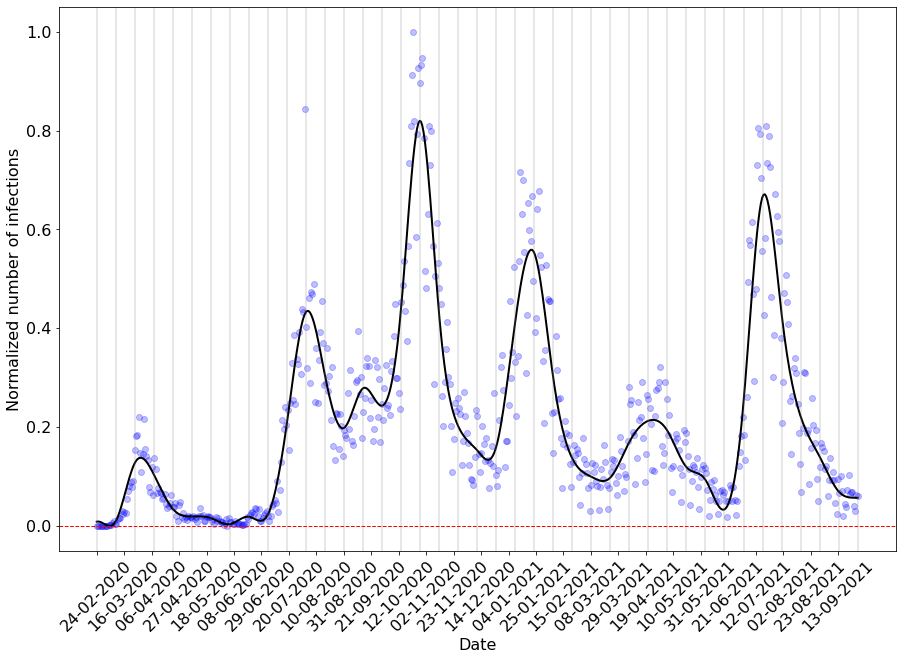

In [3]:
df = filtered_covid_df(
    response_var="num_casos",
    min_date=None,
    max_date=None, 
    sexo=[],
    provincia=["HU", "Z", "TE"],
).pipe(covid_agg_age, response_var="num_casos", normalize=True)
dates = df.index
days = get_days(df=df)
num_casos = df.values.T[0]

example1d = OneSmoothing(int_constraints={0: {0: {"+": 0}}})
example1d.fit(x=[days], y=num_casos)
# Plot the results
plot1d = plot_curves(
    fittings=[example1d],
    col_pt=["b"],
    col_curve=["k"],
    knot_positions=True,
    constant_constraints=True,
    x=[days],
    y=[num_casos]
)
fig1d, ax1d = plot1d[0], plot1d[1]
_ = ax1d.set_xticks(days[::21])
_ = ax1d.set_xticklabels(
    dates[: len(days) : 21].strftime("%d-%m-%Y").values, rotation=45
)
_ = ax1d.set_ylabel("Normalized number of infections", fontsize=16)
_ = ax1d.set_xlabel("Date", fontsize=16)
_ = ax1d.tick_params(axis="both", which="major", labelsize=16)

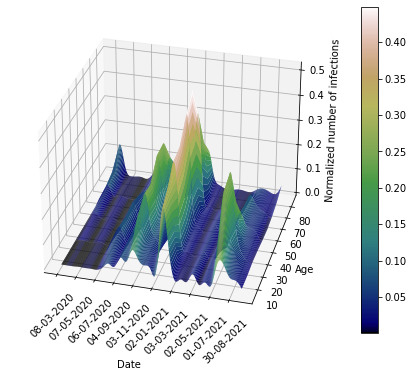

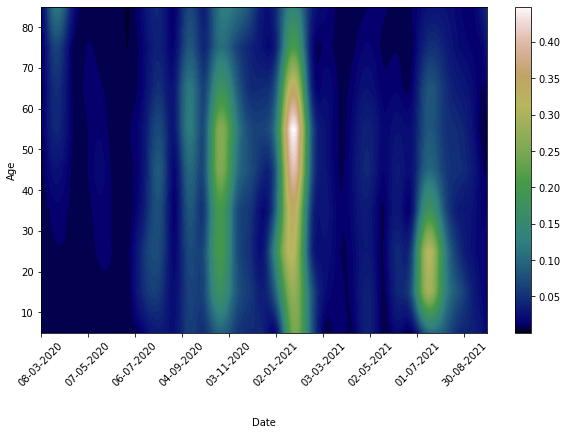

In [4]:
df = filtered_covid_df(
    response_var="num_casos",
    min_date=None,
    max_date=None,  # pd.Timestamp(2021, 8, 25),
    sexo=["H"],
    provincia=["TE"],
).pipe(covid_pivot_df, response_var="num_casos", normalize=True)

dates = df.index
days = get_days(df=df)
ages = np.array([code * 10 + 5 for code in df.columns.codes])
num_casos = df.values

example2d = OneSmoothing(deg=(3,3),
                         ord_d=(2,2),
                         n_int=(30,20),
                         int_constraints={0: {0: {"+": 0}}, 1: {0: {"+": 0}}})
example2d.fit(x=[days, ages], y=num_casos)

plot2d = plot_surfaces(
    fittings=[example2d],
    col_surface=["gist_earth"],
    contour_plot=True,
    figsize=(10, 6),
    orientation=(30, 285),
)

for fig_tuple in plot2d:
    fig2d, ax2d = fig_tuple[0], fig_tuple[1]
    _ = ax2d.set_xticks(days)
    _ = ax2d.set_xticklabels(dates.strftime("%d-%m-%Y"), rotation=45)
    _ = ax2d.xaxis.set_major_locator(plticker.MultipleLocator(base=60.0))
    _ = ax2d.set_xlabel("Date", labelpad=30)
    _ = ax2d.set_ylabel("Age")
_ = plot2d[0][1].set_zlabel("Normalized number of infections")

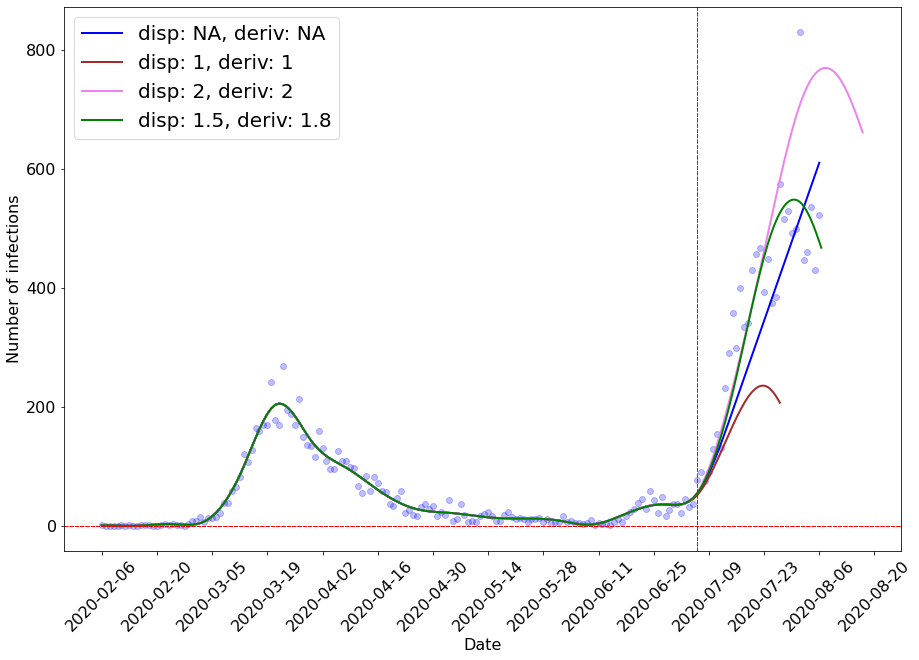

In [5]:
data_aragon = pd.read_csv(Path("../data/covid_aragon_1D.csv"))
dates = pd.to_datetime(data_aragon["fecha"]).dt.date
x_sam = data_aragon.index.values[:183]
y_sam = data_aragon["num_casos"].values[: len(x_sam)]

example_pt = OneSmoothing(deg=[3],
                              ord_d=[2],
                              n_int=[17],
                              x_range={0: (max(x_sam), )},
                              sp_method="grid_search",
                              sp_args={"grid": [[0.01]]},
                              int_constraints={0: {0: {"+": 0}}})
example_pt.fit(x=[x_sam[:152]], y=y_sam[:152])

deriv_curve = np.matmul(
    example_pt.bspline_bases[0].B_eval(pts=example_pt.bspline_bases[0].xsample,
                                       derivative=1),
    example_pt.sol,
)


factors_dict = {"factor_disp": [1, 2, 1.5], "factor_deriv": [1, 2, 1.8]}

curves = [example_pt]

for disp, deriv in zip(factors_dict["factor_disp"], factors_dict["factor_deriv"]):
    disp_deriv = displaced_forecast_covid(
        xmax=151,
        factor_disp=disp,
        factor_deriv=deriv,
        deriv=deriv_curve[30:51],
    )
    example_pt2 = OneSmoothing(deg=[3],
                                  ord_d=[2],
                                  n_int=[17],
                                  x_range={0: (disp_deriv[2], )},
                                  sp_method="grid_search",
                                  sp_args={"grid": [[0.01]]},
                                  int_constraints={0: {0: {"+": 0}}},
                                  pt_constraints={(1,): [[disp_deriv[0]], disp_deriv[1], 2]})
    example_pt2.fit(x=[x_sam[:152]], y=y_sam[:152])
    curves.append(example_pt2)

label_legend = ["disp: NA, deriv: NA"] + [
    f"disp: {disp}, deriv: {deriv}"
    for disp, deriv in zip(factors_dict["factor_disp"], factors_dict["factor_deriv"])
]
plot_pt = plot_curves(
    fittings=curves,
    col_pt=["b", "b", "b", "b"],
    col_curve=["b", "brown", "violet", "g"],
    constant_constraints=True,
    alpha=0.25,
    x=[x_sam],
    y=[y_sam],
)
fig_pt, ax_pt = plot_pt[0], plot_pt[1]
_ = ax_pt.set_xticks(dates.index[:200:14])
_ = ax_pt.set_xticklabels(dates[:200:14].values, rotation=45)
_ = ax_pt.set_ylabel("Number of infections", fontsize=16)
_ = ax_pt.set_xlabel("Date", fontsize=16)
_ = ax_pt.legend(
    ax_pt.get_legend_handles_labels()[0],
    label_legend,
    prop={"size": 20},
)
_ = ax_pt.tick_params(axis='both', which='major', labelsize=16)